In [22]:
from more_itertools import unzip
from torch.utils.data import DataLoader, Dataset, random_split
import kaggle
import zipfile
import pandas as pd
import os
from PIL import Image
from yaml import load
from torchvision import transforms
import pandas as pd
import numpy as np
import torch


class HistopathologicCancerDetectionDataset(Dataset):
    KAGGLE_DATASET = "histopathologic-cancer-detection"

    def __init__(self, data_path):
        self.data_path = data_path
        self._download()
        self.train_labels = pd.read_csv(
            os.path.join(self.data_path, "train_labels.csv")
        )
        self.transforms = transforms.Compose([transforms.Resize(224),
                                              transforms.ToTensor()],
                                             )

    def __len__(self):
        return len(self.train_labels)

    def __getitem__(self, index):
        image_id = self.train_labels["id"].iloc[index]
        label = self.train_labels["label"].iloc[index]
        img = Image.open(os.path.join(self.data_path, "train", image_id + ".tif"))
        return self.transforms(img), label

    def _download(self):
        kaggle.api.authenticate()
        kaggle.api.competition_download_files(
            self.KAGGLE_DATASET, path=self.data_path, quiet=False
        )
        # Only unzip if we cannot find certain files
        if not set(["train", "train_labels.csv"]).issubset(os.listdir(self.data_path)):
            with zipfile.ZipFile(
                os.path.join(self.data_path, self.KAGGLE_DATASET + ".zip")
            ) as zipped:
                zipped.extractall(self.data_path)


def load_data(data_path=None, test_split=0.33, batch_size=32):
    """
    Downloads the dataset from Kaggle if needed, creates a Pytorch Dataset and then
    setups data loaders for the training and test set.

    Required setup:
    1. Go to https://www.kaggle.com/<ACCOUNT_NAME>/account
    2. Click "Create New API Token"
    3. Add Token file to ~/.kaggle/kaggle.json
    """
    if not data_path:
        data_path = os.path.join(os.path.dirname(os.path.realpath(__file__)), "data")
    dataset = HistopathologicCancerDetectionDataset(data_path)
    test_size = int(len(dataset) * test_split)
    train_size = len(dataset) - test_size
    train_set, test_set = random_split(dataset, [train_size, test_size])
    train_loader = DataLoader(train_set, shuffle=True, batch_size=batch_size)
    test_loader = DataLoader(test_set, batch_size=batch_size)
    return train_loader, test_loader

In [43]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train=HistopathologicCancerDetectionDataset(data_path='.')

histopathologic-cancer-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [19]:
train_loader, test_loader=load_data(data_path='.',batch_size=1)

histopathologic-cancer-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


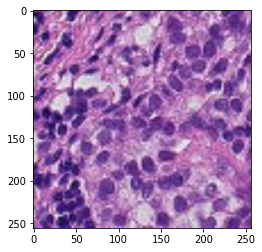

In [39]:
import matplotlib.pyplot as plt
s=(next(iter(train_loader))[0])

plt.imshow(s[0, :,:,:].permute(1, 2, 0))

In [50]:
def train_model(model, criterion, optimizer, scheduler,train_loader,val_loader, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                loader=train_loader# Set model to training mode and choose the correct dataloader
            else:
                model.eval() 
                loader=val_loader# Set model to evaluate mode and choose the correct dataloader

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for s in loader:
                inputs = s[0].to(device)
                
                #casting labels to long as float doesn't work to train the resnet
                
                labels = (s[1]).type(torch.LongTensor)
                labels = labels.to(device)
                

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(loader)
            epoch_acc = running_corrects.double() / len(loader)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            if(phase== 'train'):
                metrics={"train_loss": epoch_loss, 
                         "train_accuracy": epoch_acc}
            else:
                metrics={"val_loss": epoch_loss, 
                         "val_accuracy":epoch_acc }
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, s in enumerate(val_loader):
            inputs = s[0].to(device)
            #concat the input to change to 3 channels
            #casting labels to long as float doesn't work to train the resnet
            labels = (s[1]).type(torch.LongTensor)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
           

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {preds[j]}')
                #spliting x to visualize output to undo concat
                x=torch.split(inputs.cpu().data[j],3, dim=0)[0][0]
                plt.imshow(x)

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,train_loader, test_loader,num_epochs=25)

Epoch 0/24
----------
